In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pim_tmr as pim
import matrices as pim_mats
import fibernet
import torch
from admm import admm_tmr
import matplotlib.pyplot as plt

In [2]:
import mat73
import os
from scipy.io import loadmat

path = "C:\\Users\\saucourt\\Datasets"
file = "data_base_02_03_90deg.mat"
data = mat73.loadmat(os.path.join(path, file))
# data = loadmat(os.path.join(path, file))

In [3]:
model_path = 'C:/Users/saucourt/Coding/fibernet_analysis/training_analysis/trained_models/model_ds=10k_p=1_na=0.2_ep=40.pth'
model = torch.load(model_path)

In [4]:
def retrieve_bias(model):
    return model.bias.cpu().detach().numpy()

def retrieve_matrix(model, num_mats) -> None:
    return [params.data for i in range(num_mats) for params in model.linear_list[i].parameters()][0].cpu().detach().numpy()
    
matrix = retrieve_matrix(model, 1)
bias = retrieve_bias(model)

print(np.transpose(matrix).shape)
print(bias.shape)

(32, 14884)
(122, 122)


In [5]:
def select_pixels(img, idxs):
    idxs = idxs.astype(int)
    X, Y = np.meshgrid(idxs, idxs)
    img = img[X.flatten(), Y.flatten()]
    img = np.reshape(img, (len(idxs), len(idxs)))
    return img

In [95]:
CP = np.reshape(np.array(data['CP']), newshape=(-1, 128, 128))
vec = np.reshape(np.array(data['vecteur_36']) , newshape=(-1, 36))

NN = CP.shape[0]
As = np.zeros(shape=(NN, 32), dtype=complex)
Bs = np.zeros(shape=(NN, 122*122), dtype=float)

amp = fibernet.dataset._utils.make_bellshaped_plane_2d(vec[0].reshape((6,6)))
amp = amp.flatten()

idxs = np.arange(4, 122, 128/50).astype(int)
print(idxs.shape)
Bs = np.zeros(shape=(NN, len(idxs)**2), dtype=float)

bias = retrieve_bias(model)
# bias = select_pixels(bias, idxs)

for i in range(NN):
    phi = vec[i]
    phi = amp * np.exp(1j * phi)
    phi = np.delete(vec[i], [0, 5, 30, 35])
    img = CP[i][3:125, 3:125]
    img = select_pixels(img, idxs)
    
    # img = img - bias
    img = img.flatten().astype('float')
    As[i,:] = phi
    Bs[i,:] = np.sqrt(img)
    # Bs[i,:] = np.sqrt(img/(np.power(2, 16) - 1))

(47,)


In [112]:
torch.cuda.empty_cache()
N = 1000
# idx = np.random.permutation(np.arange(NN))
# As_crop = As[idx[:N], :]
# Bs_crop = Bs[idx[:N], :]
As_crop = As[:N, :]
Bs_crop = Bs[:N, :]

# Tolerance criterion has to be adjusted to be realistic and ensure the convergence
# X_est = admm_tmr(As_crop, Bs_crop, rho=1, max_iter=200, max_inner_iter=100, tol=1e-9, lr=1e-2, verbose=1, device='cuda')
# X_est = X_est.cpu().detach().numpy()

X_est = pim.pim_tmr(As_crop, Bs_crop, max_iter=200, tol=1e-9, tol_stag=1e-2, max_stag=10, init_wirtinger=True)

# Normalize retrieved matrix
X1 = np.abs(X_est) / np.max(np.abs(X_est)) * np.exp(1j * (np.angle(X_est) - np.angle(X_est[0, :])))

i=    0  mse_glob=1.130e-07  mse_convs=nan  mse_acts=1.130e-07  act= 2209  convs=    0
i=    1  mse_glob=1.130e-07  mse_convs=nan  mse_acts=1.130e-07  act= 2209  convs=    0
i=    2  mse_glob=1.130e-07  mse_convs=nan  mse_acts=1.130e-07  act= 2209  convs=    0
i=    3  mse_glob=1.130e-07  mse_convs=nan  mse_acts=1.130e-07  act= 2209  convs=    0
i=    4  mse_glob=1.130e-07  mse_convs=nan  mse_acts=1.130e-07  act= 2209  convs=    0
i=    5  mse_glob=1.130e-07  mse_convs=nan  mse_acts=1.130e-07  act= 2209  convs=    0
i=    6  mse_glob=1.130e-07  mse_convs=nan  mse_acts=1.130e-07  act= 2209  convs=    0
i=    7  mse_glob=1.130e-07  mse_convs=nan  mse_acts=1.130e-07  act= 2209  convs=    0
i=    8  mse_glob=1.130e-07  mse_convs=nan  mse_acts=1.130e-07  act= 2209  convs=    0
i=    9  mse_glob=1.130e-07  mse_convs=nan  mse_acts=1.130e-07  act= 2209  convs=    0
Restarting 2209 columns 
i=   10  mse_glob=1.130e-07  mse_convs=nan  mse_acts=1.130e-07  act= 2209  convs=    0
i=   11  mse_glob=

621.2392093153594


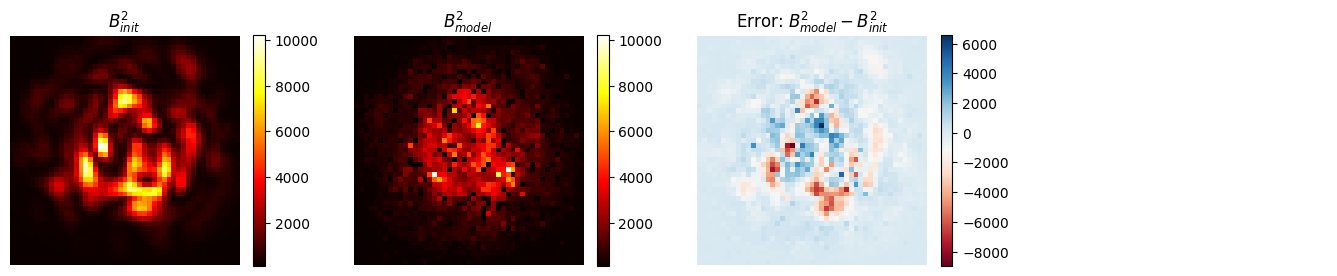

In [113]:
# i = np.random.randint(0, N)
i = 50
A_init = As_crop
Y_model = np.dot(A_init, X_est)
B_model = np.abs(Y_model)
B_init = Bs_crop

b_init_check = np.reshape(B_init[i,:], (len(idxs),len(idxs)))
b_model_check = np.reshape(B_model[i,:], (len(idxs),len(idxs)))

fig, axs = plt.subplots(1,4, figsize=(17,3))
pl0 = axs[0].imshow(np.square(b_init_check ), cmap="hot")
pl1 = axs[1].imshow(np.square(b_model_check), cmap="hot", vmin=np.min(np.square(b_init_check )), vmax=np.max(np.square(b_init_check )))
pl2 = axs[2].imshow(np.square(b_model_check) - np.square(b_init_check), cmap="RdBu")
# pl3 = axs[3].imshow(np.angle(Y_model[:,i]), cmap="twilight")
plt.colorbar(pl0, ax=axs[0])
plt.colorbar(pl1, ax=axs[1])
plt.colorbar(pl2, ax=axs[2])
# plt.colorbar(pl3, ax=axs[3])
axs[0].set_title(r"$B_{init}^2$")
axs[1].set_title(r"$B_{model}^2$")
axs[2].set_title(r"Error: $B_{model}^2 - B_{init}^2$")
# axs[3].set_title(r"$\angle Y_{model}$")
[ axs[i].axis('off') for i in range(4) ]

MSE = np.mean(np.abs(np.square(B_model) - np.square(B_init)))
print(MSE)
